## Analysis of publications related to OpenNeuro

In [1]:
import numpy as np
import pandas as pd
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as tkr 
import requests 
from datetime import datetime
import sys
import matplotlib
from collections import defaultdict

In [2]:
datadir = '../data/openneuro'
figdir = '../figures'

In [7]:
# use metadata obtained from API - based on Joe's metadata_update.py

headers = {
    'Accept-Encoding': 'gzip, deflate, br',
    'Content-Type': 'application/json',
    'Accept': 'application/json',
    'Connection': 'keep-alive',
    'DNT': '1',
    'Origin': 'https://openneuro.org',
}

query = '''
{
    edges {
        cursor,
        node {
            id,
            publishDate,
            latestSnapshot {
                tag, 
                dataset {
                    name, 
                    publishDate,
                    metadata {
                      trialCount,
                      studyDesign,
                      studyDomain,
                      studyLongitudinal,
                      dataProcessed,
                      species,
                      associatedPaperDOI,
                      openneuroPaperDOI
                      dxStatus
                    }
                }, 
                description {
                    SeniorAuthor
                },
                summary {
                    subjects,
                    modalities, 
                    secondaryModalities, 
                    subjectMetadata {
                        age
                    }, 
                    tasks,
                    dataProcessed
                }
            }
        }
    }
}
'''.replace('\n','')
data = '{"query":"query testq{datasets ' + query + '}"}'


response = requests.post('https://openneuro.org/crn/graphql', headers=headers, data=data)
response = response.json()

datasets = {}

while True:
    for y in response['data']['datasets']['edges']:
        
        datasets[y['node']['id']] = y
                
    if len(response['data']['datasets']['edges']) < 25:
        break

    next_cur = y['cursor']
    data = f'{{"query": "query testq{{datasets(after: \\"{next_cur}\\") ' + query + '}"}'
    response = requests.post('https://openneuro.org/crn/graphql', headers=headers, data=data)
    response = response.json()

In [ ]:
len(datasets)

857

In [9]:
# utility functions to clean things up - from metadata_update.py
def format_modalities(all_modalities):
        Modalities_available_list = []
        if any(('MRI_' in e for e in all_modalities)):
            all_modalities.remove('MRI')
            for m in all_modalities:
                if 'MRI' in m:
                    scan_type = scan_dict[m.split('MRI_',1)[1].lower()]
                    new_m = "MRI - " + scan_type
                    Modalities_available_list.append(new_m)
                else:
                    Modalities_available_list.append(m)
        else:
            Modalities_available_list = all_modalities
        return ', '.join(Modalities_available_list)

def format_ages(raw_age_list):
    formatted_list = []
    if raw_age_list:
        age_list = sorted([x['age'] for x in raw_age_list if x['age']])
        for key,value in age_dict.items():
            if any(x for x in age_list if x>=key[0] and x<=key[1]):
                formatted_list.append(value)        
        return ', '.join(formatted_list)
    else:
        return ''

def format_name(name):
    if not name:
        return ''
    elif ',' not in name:
        last = name.split(' ')[-1]
        first = ' '.join(name.split(' ')[0:-1])
        new_name = last + ', ' + first
        return new_name
    else:
        return name   


In [16]:
# convert to named tuple for ultimate conversion into pd data frame
# this is converted pretty much directly from metadata_update.py

scan_dict = {'anatomical':'anat','structural':'anat','functional':'func','behavioral':'beh','diffusion':'dwi','perfusion':'perf'}
age_dict = {(0,10):'0-10', (11,17):'11-17', (18,25):'18-25', (26,34):'26-34', (35,50):'35-50', (51,65):'51-65', (66,1000):'66+'}
bool_dict = {True:'yes',False:'no',None:'no'}
date_arg_format = '%m/%d/%Y'
date_input_format = '%Y-%m-%d'
date_output_format = '%-m/%-d/%Y'


output = []

for accession_Number, y in datasets.items():
    Dataset_made_public_datetime = datetime.strptime(y['node']['publishDate'][:10],date_input_format)
    Dataset_URL = os.path.join('https://openneuro.org/datasets/',accession_Number,'versions',y['node']['latestSnapshot']['tag'])
    Dataset_name = y['node']['latestSnapshot']['dataset']['name']
    Dataset_made_public = Dataset_made_public_datetime.strftime(date_output_format)
    Most_recent_snapshot_date = datetime.strptime(y['node']['latestSnapshot']['dataset']['publishDate'][:10],date_input_format).strftime(date_output_format)
    if y['node']['latestSnapshot']['summary'] is None:
        print('skipping',accession_Number)
        continue
    if y['node']['latestSnapshot']['summary'] != None:
        Number_of_subjects = len(y['node']['latestSnapshot']['summary']['subjects'])
        Modalities_available = format_modalities(y['node']['latestSnapshot']['summary']['secondaryModalities'] + y['node']['latestSnapshot']['summary']['modalities']) 
        Ages = format_ages(y['node']['latestSnapshot']['summary']['subjectMetadata'])
        Tasks_completed = ', '.join(y['node']['latestSnapshot']['summary']['tasks'])
    else:
        Number_of_subjects = len(y['node']['latestSnapshot']['summary']['subjects'])
        Modalities_available = format_modalities(y['node']['latestSnapshot']['summary']['secondaryModalities'] + y['node']['latestSnapshot']['summary']['modalities']) 
        Ages = format_ages(y['node']['latestSnapshot']['summary']['subjectMetadata'])
        Tasks_completed = ', '.join(y['node']['latestSnapshot']['summary']['tasks'])
        
    if y['node']['latestSnapshot']['dataset']['metadata'] is not None:
        DX_status = y['node']['latestSnapshot']['dataset']['metadata']['dxStatus']
        Number_of_trials = y['node']['latestSnapshot']['dataset']['metadata']['trialCount']
        Study_design = y['node']['latestSnapshot']['dataset']['metadata']['studyDesign']
        Domain_studied = y['node']['latestSnapshot']['dataset']['metadata']['studyDomain']
        Longitudinal = 'Yes' if y['node']['latestSnapshot']['dataset']['metadata']['studyLongitudinal'] == 'Longitudinal' else 'No'
        Processed_data = 'Yes' if y['node']['latestSnapshot']['dataset']['metadata']['dataProcessed'] == True else 'No'
        Species = y['node']['latestSnapshot']['dataset']['metadata']['species']
        DOI_of_paper_associated_with_DS = y['node']['latestSnapshot']['dataset']['metadata']['associatedPaperDOI']
        DOI_of_paper_because_DS_on_OpenNeuro = y['node']['latestSnapshot']['dataset']['metadata']['openneuroPaperDOI']
    else:
        DX_status = ''
        Number_of_trials = ''
        Study_design = ''
        Domain_studied = ''
        Longitudinal = ''
        Processed_data = ''
        Species = ''
        DOI_of_paper_associated_with_DS = ''
        DOI_of_paper_because_DS_on_OpenNeuro = ''

    Senior_Author = format_name(y['node']['latestSnapshot']['description']['SeniorAuthor'])
    line_raw = [accession_Number,Dataset_URL,Dataset_name,Dataset_made_public,Most_recent_snapshot_date,Number_of_subjects, \
        Modalities_available,DX_status,Ages,Tasks_completed,Number_of_trials,Study_design,Domain_studied,Longitudinal,Processed_data, \
            Species,DOI_of_paper_associated_with_DS,DOI_of_paper_because_DS_on_OpenNeuro,Senior_Author]
    line = ['' if x == None else str(x) for x in line_raw]
    output.append(line)


skipping ds002385
skipping ds003766
skipping ds003816
skipping ds005079
skipping ds005270


In [17]:
colnames = ['AccessionNumber', 'Dataset URL', 'Dataset name', 'ReleaseDate',
       'Most recent snapshot date (MM/DD/YYYY)', 'NSubjects', 'Modalities',
       'DX status(es)', 'Ages (range)', 'Tasks completed?',
       '# of trials (if applicable)', 'Study design', 'Domain studied',
       'Longitudinal?', 'Processed data?', 'Species',
       'DOI of paper associated with DS (from submitter lab)',
       'DOI of paper because DS on OpenNeuro',
       'Senior Author (lab that collected data) Last, First']

metadata = pd.DataFrame(output, columns=colnames)
metadata['NSubjects'] = [int(i) for i in metadata['NSubjects']]
metadata.to_csv('../data/openneuro/metadata_sheet.csv')

In [18]:
metadata['ReleaseDate'] = pd.to_datetime(metadata['ReleaseDate'])

# Collapse any dates prior to 07/17/2018 when OpenfMRI datasets were uploaded
#metadata.loc[metadata["ReleaseDate"] < "2018-07-17", "ReleaseDate"] = "2018-07-17"

## Statistics on the database

In [19]:
print('Number of datasets:', len(metadata['Dataset name'].unique()))
print('Number of datasets:', len(metadata['AccessionNumber'].unique()))


Number of datasets: 1057
Number of datasets: 1090


In [20]:
print('Number of subjets:', metadata['NSubjects'].sum())


Number of subjets: 47535


In [21]:
data_paper_dois = metadata['DOI of paper associated with DS (from submitter lab)'].unique()
print(f'Number of data paper DOIs: {data_paper_dois.shape[0]}')
print(f'Proportion of data paper DOIs: {data_paper_dois.shape[0]/metadata.shape[0]}')

Number of data paper DOIs: 236
Proportion of data paper DOIs: 0.21651376146788992


In [22]:
user_paper_dois = metadata['DOI of paper because DS on OpenNeuro'].unique()
print(f'Number of user paper DOIs: {user_paper_dois.shape[0]}')

Number of user paper DOIs: 153


Clean up data to create plots

In [23]:
df_sorted = metadata.sort_values('ReleaseDate')
df_sorted['ones'] = 1
df_sorted['cumulative'] = df_sorted['ones'].cumsum()
df_sorted['cumulative_subjects'] = df_sorted['NSubjects'].cumsum()
dates = df_sorted['ReleaseDate'].unique()
print('Earliest dataset:', dates.min())
print('Latest dataset:', dates.max())

# fix dates to reflect fact that early datasets were all from openneuro
#df_sorted.loc[df_sorted['ReleaseDate'] < pd.Timestamp(2018,8,1), 'ReleaseDate'] = '2018-08-01'
df_sorted

Earliest dataset: 2016-10-12T00:00:00.000000000
Latest dataset: 2024-06-24T00:00:00.000000000


,AccessionNumber,Dataset URL,Dataset name,ReleaseDate,Most recent snapshot date (MM/DD/YYYY),NSubjects,Modalities,DX status(es),Ages (range),Tasks completed?,...,Domain studied,Longitudinal?,Processed data?,Species,DOI of paper associated with DS (from submitter lab),DOI of paper because DS on OpenNeuro,"Senior Author (lab that collected data) Last, First",ones,cumulative,cumulative_subjects
0,ds000001,https://openneuro.org/datasets/ds000001/versio...,ds001,2016-10-12,10/12/2016,16,"MRI - func, MRI - anat",,"18-25, 26-34",balloon analog risk task,...,,No,No,,,,"Poldrack, Russell A.",1,1,16
1,ds000002,https://openneuro.org/datasets/ds000002/versio...,Classification learning,2016-10-12,10/12/2016,17,"MRI - func, MRI - anat",,"18-25, 26-34","deterministic classification, mixed event-rela...",...,,No,No,,,,"Poldrack, R.A.",1,2,33
2,ds000003,https://openneuro.org/datasets/ds000003/versio...,Rhyme judgment,2016-10-13,10/13/2016,13,"MRI - anat, MRI - func",,"18-25, 26-34, 35-50",rhyme judgment,...,,No,No,,,,"Poldrack, Russell A.",1,3,46
3,ds000005,https://openneuro.org/datasets/ds000005/versio...,ds000005,2016-10-13,10/13/2016,16,"MRI - func, MRI - anat",,"18-25, 26-34",mixed-gambles task,...,,No,No,,,,"R.A., Poldrack",1,4,62
4,ds000006,https://openneuro.org/datasets/ds000006/versio...,ds000006,2016-10-13,10/13/2016,14,"MRI - func, MRI - anat",,"18-25, 26-34, 35-50",living-nonliving decision with plain or mirror...,...,,No,No,,,,"Poldrack, RA",1,5,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,ds005250,https://openneuro.org/datasets/ds005250/versio...,Single-echo/multi-echo comparison pilot,2024-06-20,6/20/2024,8,"MRI - func, MRI - anat",Healthy / Control,"18-25, 26-34","rest eyes open, Penn fractal n-back",...,,Yes,No,Human,,,"Satterthwaite, Theodore D.",1,1086,47388
1084,ds005263,https://openneuro.org/datasets/ds005263/versio...,SoCal Kinesia and Incentivization for Parkinso...,2024-06-20,6/20/2024,68,"MRI - func, MRI - anat",Healthy / Control,,incenreach,...,Parkinson's Disease,No,No,Human,,"Dundon, N. M., Rizor, E., Stasiak, J., Wang, J...","Grafton, Scott T.",1,1087,47456
1076,ds005230,https://openneuro.org/datasets/ds005230/versio...,Reinforcement-Learning Generalization,2024-06-21,6/21/2024,44,"MRI - func, MRI - anat",Healthy / Control,,"Reinforcement Learning - Baseline, Reinforceme...",...,Motor learning,No,No,Human,,,"Gale, Dan",1,1088,47500
1089,ds005273,https://openneuro.org/datasets/ds005273/versio...,Neural representation of consciously seen and ...,2024-06-22,6/22/2024,33,EEG,Healthy / Control,,1,...,Perceptual awareness,No,No,Human,,,"González-López, José A.",1,1089,47533


In [24]:

datasets = defaultdict(lambda: 0)
subjects = defaultdict(lambda: 0)

for date, nsub in metadata[["ReleaseDate", "NSubjects"]].values:
    datasets[date.strftime('%Y-%m-%d')] += 1
    subjects[date.strftime('%Y-%m-%d')] += nsub

datadict = defaultdict(list)
for k in datasets.keys():
    datadict["ReleaseDate"].append(k)
    datadict["n_datasets"].append(datasets[k])
    datadict["n_subjects"].append(subjects[k])
    
df_plotting = pd.DataFrame(datadict)
df_plotting['ReleaseDate'] = pd.to_datetime(df_plotting['ReleaseDate'])
df_plotting = df_plotting.set_index("ReleaseDate").sort_values(by="ReleaseDate")

df_plotting["cumsum_datasets"] = df_plotting['n_datasets'].cumsum()
df_plotting['cumsum_subjects'] = df_plotting['n_subjects'].cumsum()

release_dates = df_plotting.index.astype(int)

df_plotting

,n_datasets,n_subjects,cumsum_datasets,cumsum_subjects
ReleaseDate,,,,
2016-10-12,2,33,2,33
2016-10-13,6,91,8,124
2016-10-14,6,128,14,252
2016-10-17,2,54,16,306
2016-10-25,1,99,17,405
...,...,...,...,...
2024-06-18,1,241,1081,47192
2024-06-20,6,264,1087,47456
2024-06-21,1,44,1088,47500


In [25]:
print(f"OpenNeuro surpassed the 10k datasets on {df_plotting[df_plotting['cumsum_subjects'] > 10000].index[0].strftime('%B %d, %Y')}")
print(f"The latest report from {df_plotting.index[-1].strftime('%B %d, %Y')} yields {df_plotting['cumsum_datasets'].iloc[-1]} datasets, and {df_plotting['cumsum_subjects'].iloc[-1]} subjects")

OpenNeuro surpassed the 10k datasets on April 30, 2020
The latest report from June 24, 2024 yields 1090 datasets, and 47535 subjects


In [26]:
end_year = 24 # set to current year + 1
midyears = pd.to_datetime([f"20{yr}-07-02" for yr in range(18, end_year)]).astype(int)  # July 2 is the midpoint of year
midyears

Int64Index([1530489600000000000, 1562025600000000000, 1593648000000000000,
            1625184000000000000, 1656720000000000000, 1688256000000000000],
           dtype='int64')

Plot # of datasets over time

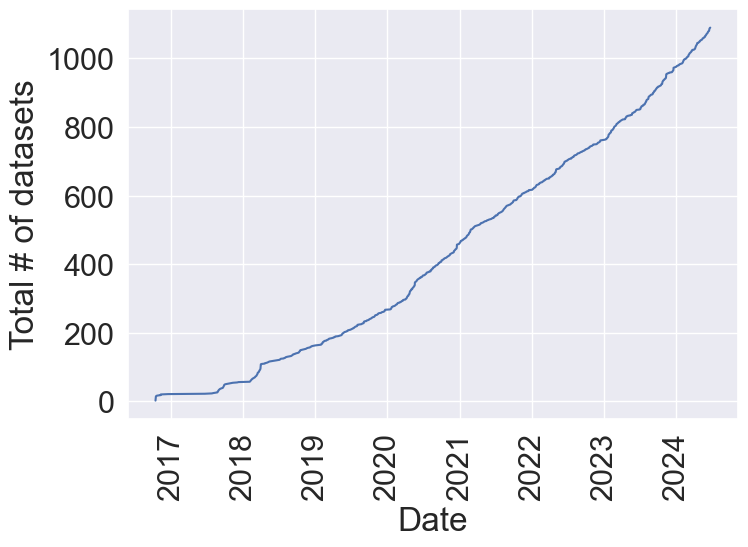

In [27]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)  # crazy big
sns.lineplot(x='ReleaseDate', y='cumsum_datasets', data=df_plotting)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total # of datasets')
plt.tight_layout()
# plt.savefig(os.path.join(figdir, 'n_datasets.pdf'))

Plot # of subjects over time

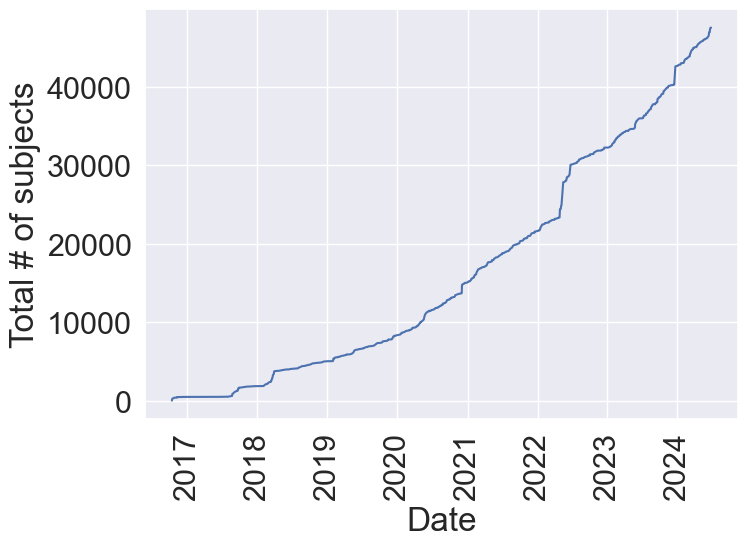

In [28]:
plt.figure(figsize=(8,6))
sns.set(font_scale=2)  # crazy big
sns.lineplot(x='ReleaseDate', y='cumsum_subjects', data=df_plotting)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Total # of subjects')
plt.tight_layout()
# plt.savefig(os.path.join(figdir, 'n_subjects.pdf'))

Plot both together

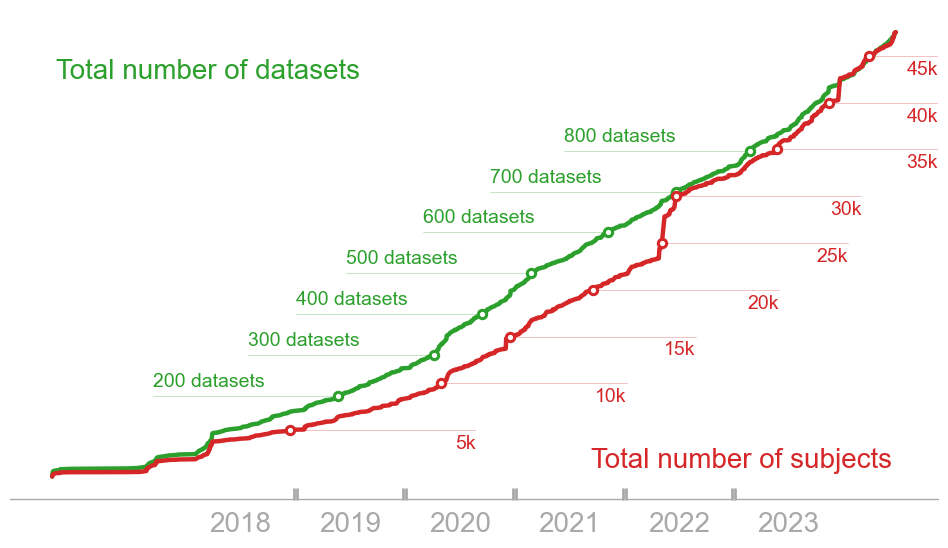

In [29]:
# plotting code from Oscar Esteban
# requires a bit of tweaking when years change

font_to_use = 'Arial'

# Edit general skin
sns.set_style('whitegrid')
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot Datasets
color = 'tab:green'
ax1.set_xlabel('Date', fontsize=20)
ax1 = sns.lineplot(x=release_dates, y=df_plotting['cumsum_datasets'], 
                   color=color, label='Datasets', linewidth=3.2)
# Plot Subjects
ax2 = ax1.twinx()
color = 'tab:red'
ax2 = sns.lineplot(x=release_dates, y=df_plotting['cumsum_subjects'],
                   color=color, label='Subjects', linewidth=3.2)
# Grid & spines
ax1.grid(False)
ax2.grid(False)
ax1.spines.left.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.spines.bottom.set_visible(False)
ax2.spines.bottom.set_visible(False)
# ax1.spines.bottom.set_position(('outward', 10))

# Manipulate axes
ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax1.get_legend().remove()
ax2.get_legend().remove()

# Place year label at the middle of each year
ax1.set_xticks(midyears)
ax1.set_xticklabels([f"20{yr}" for yr in range(18, end_year)], fontsize=20, color="darkgray")

# Annotate total datasets
x_lim = ax1.get_xlim()
y1_lim = ax1.get_ylim()
normalized_dates = (release_dates - x_lim[0]) / (x_lim[1] - x_lim[0])
num_ds = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
x_dates_norm = np.interp(num_ds, df_plotting['cumsum_datasets'], normalized_dates)
x_dates = np.interp(num_ds, df_plotting["cumsum_datasets"], release_dates)
y1_norm = (np.array(num_ds) - y1_lim[0]) / (y1_lim[1] - y1_lim[0])

for y, x, y_norm in zip(num_ds, x_dates_norm, y1_norm):
    xorig = max(x - 0.2, 0)
    ax1.axhline(y=y, xmax=x, xmin=xorig, color='tab:green', alpha=0.4, linewidth=0.5)
    ax1.text(xorig, y_norm + 0.01, f"{y} datasets",
             transform=ax1.transAxes,
             verticalalignment='bottom', horizontalalignment='left',
             color='tab:green', fontsize=14)

ax1.plot(
    x_dates,
    num_ds,
    marker="o",
    markeredgecolor="tab:green",
    markerfacecolor="white",
    color="white",
    ms=6,
    markeredgewidth=2.2,
    fillstyle="full",
    linestyle="None",
)
    
# Annotate total subjects
num_subj = np.arange(5000, metadata['NSubjects'].sum(), 5000)

x_subj_dates = np.interp(num_subj, df_plotting['cumsum_subjects'], normalized_dates)
x2_dates = np.interp(num_subj, df_plotting["cumsum_subjects"], release_dates)
y2_lim = ax2.get_ylim()
y2_norm = (np.array(num_subj) - y2_lim[0]) / (y2_lim[1] - y2_lim[0])
for y, x, y_norm in zip(num_subj, x_subj_dates, y2_norm):
    xend = min(x + 0.2, 1.0)
    ax2.axhline(y=y, xmin=x, xmax=xend, color='tab:red', alpha=0.4, linewidth=0.5)
    ax2.text(xend, y_norm - 0.01, f"{y // 1000}k",
             transform=ax2.transAxes,
             verticalalignment='top', horizontalalignment='right',
             color='tab:red', fontsize=14)
    
ax2.plot(
    np.interp(num_subj, df_plotting["cumsum_subjects"], release_dates),
    num_subj,
    marker="o",
    markeredgecolor="tab:red",
    markerfacecolor="white",
    color="white",
    ms=6,
    markeredgewidth=2.2,
    fillstyle="full",
    linestyle="None",
)

# Add Y-axis labels in the middle of the plot, linked by color
ax2.text(0.05, 0.9, 'Total number of datasets',
         verticalalignment='top', horizontalalignment='left',
         transform=ax2.transAxes,
         color='tab:green',  fontsize=20)

ax2.text(0.95, 0.05, 'Total number of subjects',
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax2.transAxes,
         color='tab:red',  fontsize=20)

# Replace X-axis with a fancier timeline plot
years = pd.to_datetime(["2018-01-05", "2018-12-26",
                    "2019-01-05", "2019-12-26",
                    "2020-01-05", "2020-12-26",
                    "2021-01-05", "2021-12-26",
                    '2022-01-05', '2022-12-26', 
                    '2023-01-05', '2023-12-26']).astype(int).values
years_norm = (years - x_lim[0]) / (x_lim[1] - x_lim[0])
years_norm[0] = 0.0
years_norm[-1] = 1.0

for yr_start, yr_end in years_norm.reshape(-1, 2):
    ax1.axhline(
        y1_lim[0],
        xmin=yr_start,
        xmax=yr_end,
        clip_on=False,
        color="darkgray",
        linewidth=1,
    )

for yr in years[1:-1]:
    ax1.axvline(
        yr,
        ymin=0,
        ymax=0.02,
        clip_on=False,
        color="darkgray",
        linewidth=2,
    )        
        
ax1.set_yticks([])
ax2.set_yticks([])
        
plt.tight_layout()
plt.savefig(os.path.join(figdir, 'combined_growth.png'))
plt.savefig(os.path.join(figdir, 'combined_growth.pdf'))

## analysis of data types: species

In [ ]:
# clean up labels
cleanup_dict = {'Mice': 'Mouse',
               'Rats': 'Rat',
                'rat': 'Rat',
                'Adult Wistar rats': 'Rat',
               'C57bl/6 mixed gender mice': 'Mouse',
                'Mice B6/129P': 'Mouse',
               'mouse': 'Mouse',
               'Macaque': 'NHP',
               'mouse lemur': 'NHP'}

species_counts_clean = {'Mouse': 0,
                        'Rat': 0,
                       'Human': 0,
                       'Phantom': 0,
                       'NHP': 0}

for idx in df_sorted.index:
    if df_sorted.loc[idx,'Species'] in cleanup_dict:
        df_sorted.loc[idx, 'Species'] = cleanup_dict[df_sorted.loc[idx,'Species']]

species_counts = df_sorted['Species'].value_counts()
#for i in range(species_counts.loc['Mice and Rats']):
#    species_counts.loc['Mouse'] = species_counts.loc['Mouse'] + 1
#    species_counts.loc['Rat'] = species_counts.loc['Rat'] + 1
#species_counts.drop('Mice and Rats', inplace=True)
print('Total # of datasets:', species_counts.sum())
for i in species_counts.to_markdown().split('\n'):
    print(i)

Total # of datasets: 796
|                 |   Species |
|:----------------|----------:|
|                 |       392 |
| Human           |       379 |
| Rat             |        11 |
| Mouse           |         8 |
| synthetic fibre |         1 |
| MEG DBS Phantom |         1 |
| canine          |         1 |
| Monkey          |         1 |
| Sheep           |         1 |
| NHP             |         1 |


In [ ]:
species_counts/species_counts.sum()

                   0.492462
Human              0.476131
Rat                0.013819
Mouse              0.008794
Mice B6/129P       0.001256
synthetic fibre    0.001256
MEG DBS Phantom    0.001256
canine             0.001256
Monkey             0.001256
Sheep              0.001256
NHP                0.001256
Name: Species, dtype: float64

## analysis of data types: modality

In [ ]:

modalities = df_sorted['Modalities'].dropna()

mod_list = defaultdict(lambda: 0)

for i in modalities:
    for k in i.split(','):
        k = k.lstrip().lower()
        mod_list[k] = mod_list[k] + 1

In [ ]:
mod_df = pd.Series(mod_list)
md = mod_df.sort_values(ascending=False).to_markdown()
for i in md.split('\n'):
    print(i)

|             |   0 |
|:------------|----:|
| mri - anat  | 608 |
| mri - func  | 525 |
| eeg         | 137 |
| mri - dwi   |  66 |
| meg         |  33 |
| events      |  25 |
| t1w         |  20 |
| bold        |  19 |
| ieeg        |  15 |
| channels    |  13 |
| pet         |   7 |
| fieldmap    |   5 |
| mri - perf  |   3 |
| pet_dynamic |   3 |
| electrodes  |   2 |
| sbref       |   2 |
| beh         |   1 |
| mri         |   1 |
| t2w         |   1 |
| dwi         |   1 |
|             |   1 |
| coordsystem |   1 |
| 14          |   1 |
| 13          |   1 |
| 02          |   1 |
| 01          |   1 |
| pet_static  |   1 |
| t1map       |   1 |


## Analysis of dataset size

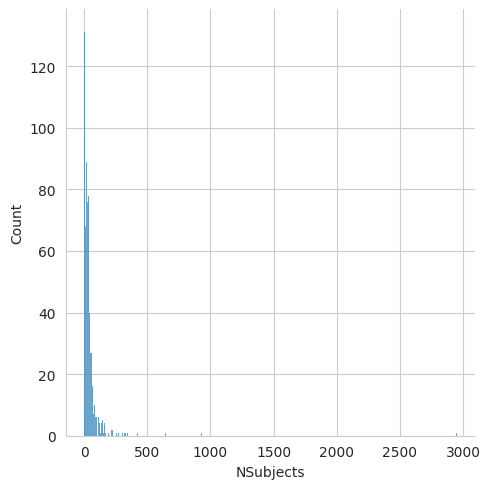

In [ ]:
# number of subjects
import numpy as np
df_sorted['nsubs'] = df_sorted['NSubjects']
nsubs = df_sorted.query('nsubs > 0')['NSubjects']
sns.displot(nsubs) #, log_scale=True)

In [ ]:
print('median # of subjects:', nsubs.median())


median # of subjects: 24.0


In [ ]:
print('# of datasets with more than 100 subjects', (nsubs > 100).sum())

# of datasets with more than 100 subjects 49


In [ ]:
print('maximum dataset size:', nsubs.max())

maximum dataset size: 2951


## Analysis of sessions

Using data obtained from datalad datasets

In [ ]:
datalad_metadata = pd.read_csv('../data/openneuro/ds_info.csv')
datalad_metadata.head()

,Unnamed: 0


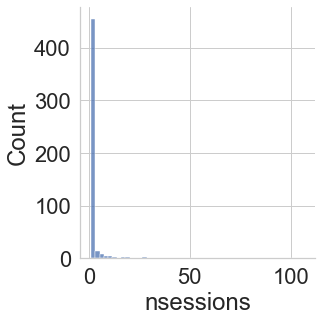

In [ ]:
sns.displot(datalad_metadata.nsessions, bins=50)

In [ ]:
print('max # of sessions:', datalad_metadata.nsessions.max())
print('# of datasets with more than 1 session:', (datalad_metadata.nsessions > 1).sum())


max # of sessions: 107
# of datasets with more than 1 session: 128


In [ ]:
# further analysis of tasks is done in task_analysis.ipynb
print('max # of tasks:', datalad_metadata.ntasks.max())
print('# of datasets with more than 1 task:', (datalad_metadata.ntasks > 1).sum())


max # of tasks: 48
# of datasets with more than 1 task: 202


## Analysis of publications

In [ ]:
print('Proportion of papers with a DOI:',
      df_sorted['DOI of paper associated with DS (from submitter lab)'].dropna().shape[0]/df_sorted.shape[0])

Proportion of papers with a DOI: 0.623841059602649


In [ ]:
dois = []
multi_doi = 0
for i in df_sorted['DOI of paper associated with DS (from submitter lab)'].dropna():
    i_s = i.split(',')
    if len(i_s) > 1:
        multi_doi += 1
    dois = dois + i_s
    
print('# of papers associated with more than one DOI:', multi_doi)
print('# of unique DOIs:', len(set(dois)))

# of papers associated with more than one DOI: 69
# of unique DOIs: 643


## figure showing width/breadth/depth

In [ ]:
datalad_metadata.shape

(0, 1)

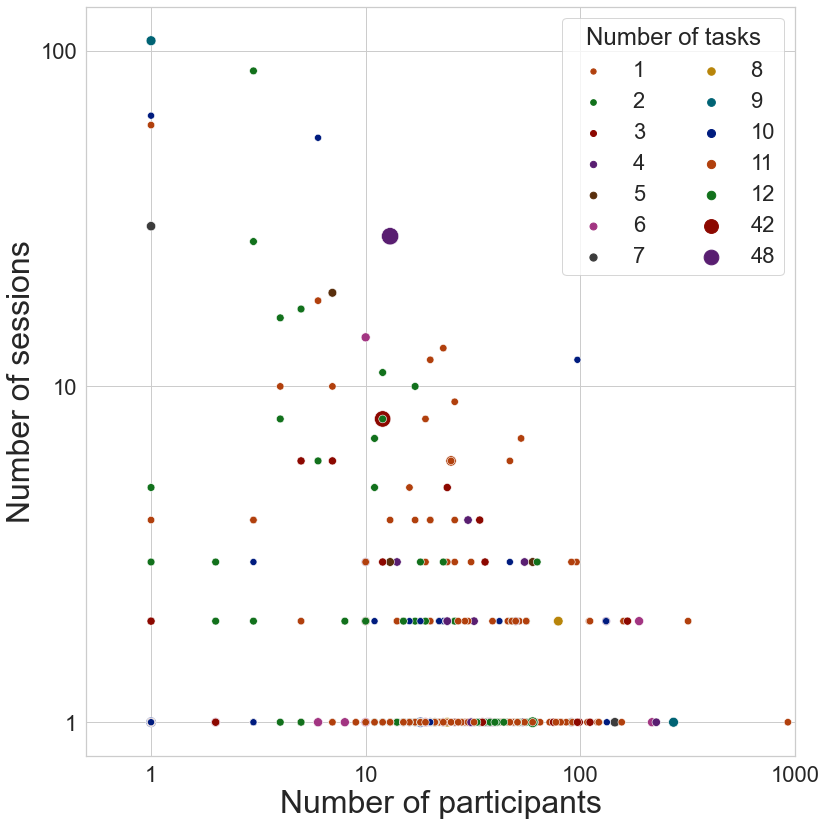

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 12))
splot = sns.scatterplot(x='nsubs', y='nsessions', size='ntasks', hue='ntasks',
                         data=datalad_metadata,
                        sizes=(50, 300), palette="dark",
                        legend = 'brief')

splot.set(xscale="log")
splot.set(yscale="log")
plt.xlim([.5, 1000])
plt.xlabel('Number of participants', fontsize=32)
plt.ylabel('Number of sessions', fontsize=32)

leg = splot.axes.get_legend()
new_title = '# of tasks'
leg.set_title(new_title)

for axis in [splot.xaxis, splot.yaxis]:
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    axis.set_major_formatter(formatter)

handles, labels = splot.get_legend_handles_labels()
for i, h in enumerate(handles[1:15]):
    h.set_sizes([24 + int(labels[i+1])*4])
splot.legend(handles=handles[1:15], labels=labels[1:15], loc=1, 
            ncol=2, bbox_to_anchor=(1,1), title='Number of tasks')
plt.tight_layout()
plt.savefig('../figures/dataset_size.pdf')


In [ ]:
dir(handles[0])

['_A',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiaseds',
 '_axes',
 '_bcast_lwls',
 '_callbacks',
 '_capstyle',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_default_contains',
 '_edge_default',
 '_edge_is_mapped',
 '_edgecolors',
 '_face_is_mapped',
 '_facecolors',
 '_factor',
 '_get_clipping_extent_bbox',
 '_get_default_antialiased',
 '_get_default_edgecolor',
 '_get_default_facecolor',
 '_get_default_linewidth',
 '_gid',
 '_hatch',
 '_hatch_color',
 '_id_norm',
 '_in_layout',
 '_joinstyle',
 '_label',
 '_linestyles',
 '_linewidths',
 '_mapped_colors',

In [ ]:
labels

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '42',
 '48',
 '0',
 '8',
 '16',
 '24',
 '32',
 '40',
 '48']